In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings(action="ignore")
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
# Define directories
MildDemented_dir = r"../MRI Datasets/Alzheimer's Augmented Dataset/AugmentedAlzheimerDataset/MildDemented"
ModerateDemented_dir = r"../MRI Datasets/Alzheimer's Augmented Dataset/AugmentedAlzheimerDataset/ModerateDemented"
NonDemented_dir = r"../MRI Datasets/Alzheimer's Augmented Dataset/AugmentedAlzheimerDataset/NonDemented"
VeryMildDemented_dir = r"../MRI Datasets/Alzheimer's Augmented Dataset/AugmentedAlzheimerDataset/VeryMildDemented"

directories = {
    'MildDemented': MildDemented_dir,
    'ModerateDemented': ModerateDemented_dir,
    'NonDemented': NonDemented_dir,
    'VeryMildDemented': VeryMildDemented_dir
}

In [3]:
# Step 1: Analyze Dataset
def analyze_dataset(directories):
    """Analyze and visualize dataset characteristics"""
    data_analysis = {}
    sample_images = {}
    counts = {}
    
    plt.figure(figsize=(20, 10))
    
    for idx, (label, directory) in enumerate(directories.items(), 1):
        images = os.listdir(directory)
        counts[label] = len(images)
        
        # Store sample image
        sample_img = Image.open(os.path.join(directory, images[0]))
        plt.subplot(2, 4, idx)
        plt.imshow(sample_img)
        plt.title(f'{label}\nCount: {counts[label]}')
        plt.axis('off')
        
        # Analyze image characteristics
        sizes = []
        channels = []
        for img_name in images[:100]:  # Sample first 100 images
            img = Image.open(os.path.join(directory, img_name))
            sizes.append(img.size)
            channels.append(len(img.getbands()))
            
        data_analysis[label] = {
            'sizes': set(sizes),
            'channels': set(channels)
        }
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nDataset Statistics:")
    for label, stats in data_analysis.items():
        print(f"\n{label}:")
        print(f"Number of images: {counts[label]}")
        print(f"Unique image sizes: {stats['sizes']}")
        print(f"Color channels: {stats['channels']}")
    
    return counts, data_analysis

In [4]:
# Step 2: Prepare Labels
def prepare_labels(directories):
    """Create label mapping and encoder"""
    label_encoder = LabelEncoder()
    class_names = list(directories.keys())
    label_encoder.fit(class_names)
    
    label_mapping = {name: idx for idx, name in enumerate(label_encoder.classes_)}
    
    print("\nLabel Mapping:")
    for class_name, idx in label_mapping.items():
        print(f"{class_name}: {idx}")
    
    return label_encoder, label_mapping

In [5]:
# Step 3: Load and Preprocess Data
def load_and_preprocess_data(directories, label_mapping, target_size=(64, 64)):
    """Load, preprocess images, and create labels"""
    images = []
    labels = []
    
    for class_name, directory in directories.items():
        print(f"\nProcessing {class_name} images...")
        class_idx = label_mapping[class_name]
        
        for img_name in os.listdir(directory):
            # Load and preprocess image
            img_path = os.path.join(directory, img_name)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)
            img_array = np.array(img) / 255.0  # Normalize
            
            images.append(img_array)
            labels.append(class_idx)
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    # Reshape for CNN
    X = X.reshape(-1, target_size[0], target_size[1], 1)
    
    # Convert labels to one-hot encoding
    y = tf.keras.utils.to_categorical(y)
    
    return X, y

In [6]:
# Step 4: Create Model
def create_model(input_shape=(64, 64, 1), num_classes=4):
    """Create CNN model"""
    model = tf.keras.models.Sequential([
        # First Convolutional Layer
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2)),
        
        # Second Convolutional Layer
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2)),
        
        # Third Convolutional Layer
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2)),
        
        # Fourth Convolutional Layer
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2)),
        
        # Flatten and Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [7]:
# Step 5: Train Model and Plot Results
def train_and_plot(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """Train model and plot training history"""
    # Define early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_custom_model.keras',            
        monitor='val_accuracy',         
        save_best_only=True,        
        mode='max',                 
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint]
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return history

In [8]:
# Step 6: Evaluate Model
def evaluate_model(model, X_test, y_test, label_encoder):
    """Evaluate model and display results"""
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Convert to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Convert to original class names
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    y_test_labels = label_encoder.inverse_transform(y_test_classes)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred_labels))
    
    # Print test accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

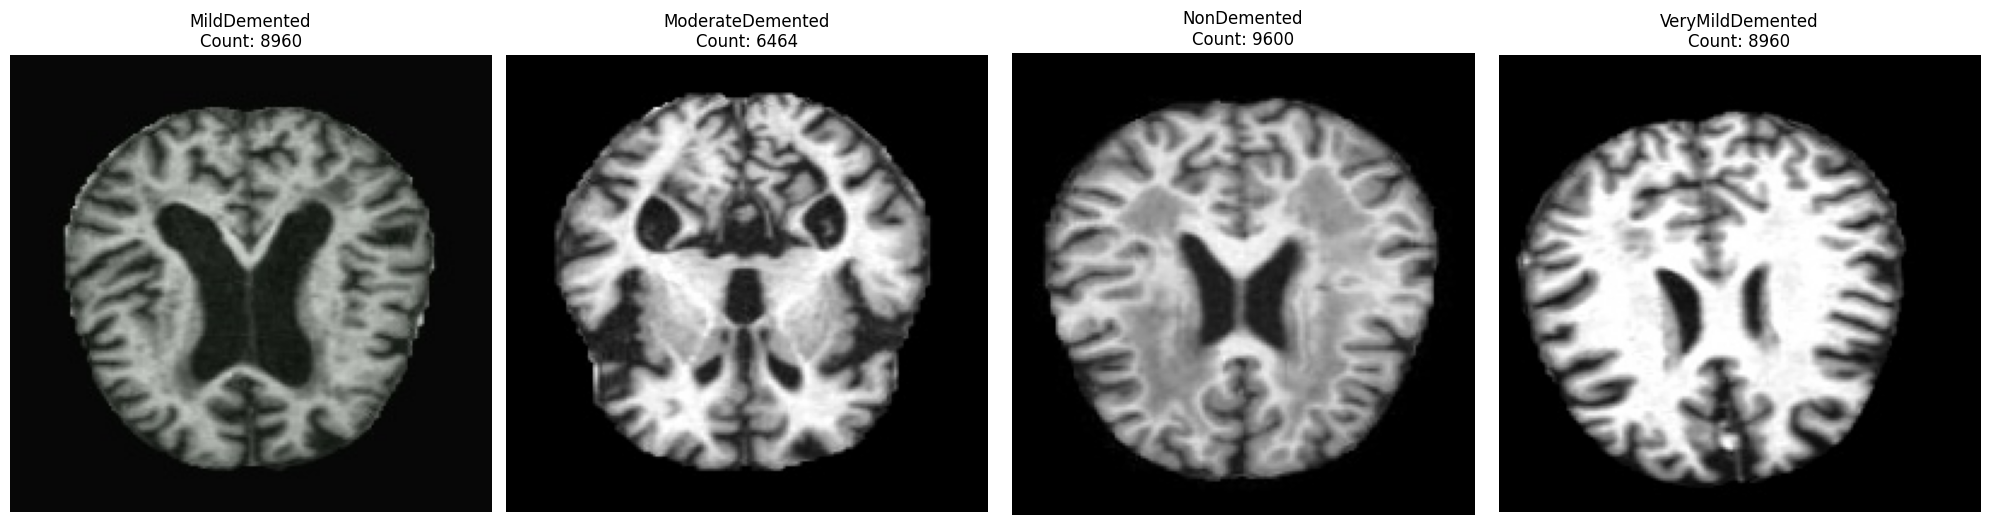


Dataset Statistics:

MildDemented:
Number of images: 8960
Unique image sizes: {(180, 180), (200, 190)}
Color channels: {3}

ModerateDemented:
Number of images: 6464
Unique image sizes: {(180, 180), (200, 190)}
Color channels: {3}

NonDemented:
Number of images: 9600
Unique image sizes: {(180, 180), (200, 190)}
Color channels: {3}

VeryMildDemented:
Number of images: 8960
Unique image sizes: {(180, 180), (200, 190)}
Color channels: {3}


In [9]:
# 1. Analyze dataset
counts, data_analysis = analyze_dataset(directories)

In [10]:
# 2. Prepare labels
label_encoder, label_mapping = prepare_labels(directories)


Label Mapping:
MildDemented: 0
ModerateDemented: 1
NonDemented: 2
VeryMildDemented: 3


In [11]:
# 3. Load and preprocess data
X, y = load_and_preprocess_data(directories, label_mapping)


Processing MildDemented images...

Processing ModerateDemented images...

Processing NonDemented images...

Processing VeryMildDemented images...


In [12]:
# 4. Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\nData Split Sizes:")
print(f"Training: {X_train.shape[0]} images")
print(f"Validation: {X_val.shape[0]} images")
print(f"Test: {X_test.shape[0]} images")


Data Split Sizes:
Training: 23788 images
Validation: 5098 images
Test: 5098 images


In [13]:
# 5. Create model
model = create_model(num_classes=len(label_mapping))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,571,972 (6.00 MB)

 Trainable params: 1,571,012 (5.99 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.4402 - loss: 1.4907
Epoch 1: val_accuracy improved from -inf to 0.52217, saving model to best_custom_model.keras
744/744 ━━━━━━━━━━━━━━━━━━━━ 216s 258ms/step - accuracy: 0.4403 - loss: 1.4901 - val_accuracy: 0.5222 - val_loss: 1.0208
Epoch 2/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6371 - loss: 0.7622
Epoch 2: val_accuracy did not improve from 0.52217
744/744 ━━━━━━━━━━━━━━━━━━━━ 188s 253ms/step - accuracy: 0.6371 - loss: 0.7622 - val_accuracy: 0.4400 - val_loss: 1.3919
Epoch 3/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7196 - loss: 0.6038
Epoch 3: val_accuracy improved from 0.52217 to 0.77501, saving model to best_custom_model.keras
744/744 ━━━━━━━━━━━━━━━━━━━━ 205s 276ms/step - accuracy: 0.7197 - loss: 0.6037 - val_accuracy: 0.7750 - val_loss: 0.5218
Epoch 4/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8065 - loss: 0.4406
Epoch 4: val_accuracy did not improve from 0.

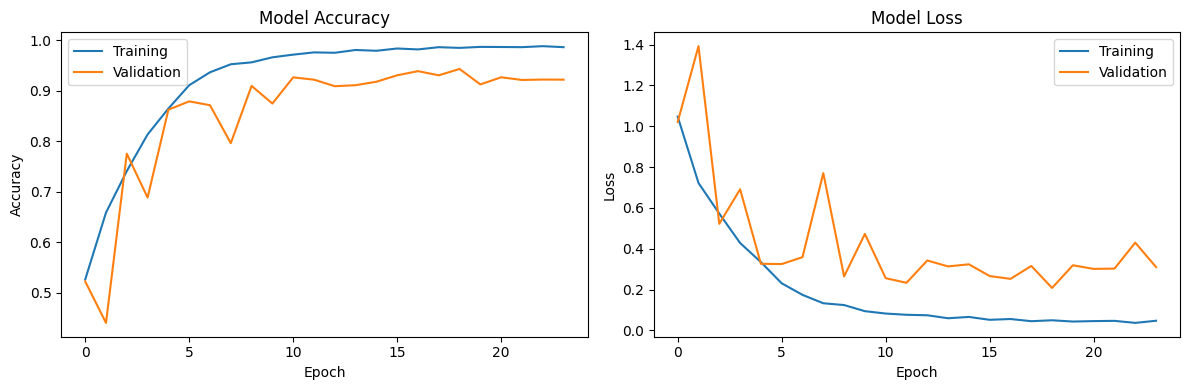

In [14]:
# 6. Train model
history = train_and_plot(model, X_train, y_train, X_val, y_val)

In [15]:
model.save("CNN.keras")

160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step


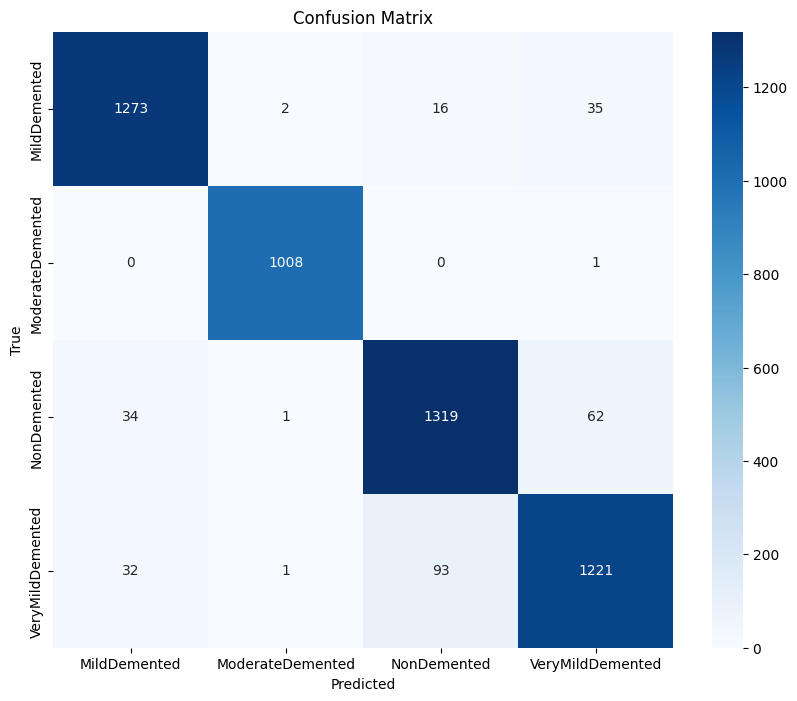


Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.95      0.96      0.96      1326
ModerateDemented       1.00      1.00      1.00      1009
     NonDemented       0.92      0.93      0.93      1416
VeryMildDemented       0.93      0.91      0.92      1347

        accuracy                           0.95      5098
       macro avg       0.95      0.95      0.95      5098
    weighted avg       0.95      0.95      0.95      5098

160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9507 - loss: 0.1730

Test Accuracy: 0.9457


In [16]:
# 7. Evaluate model
evaluate_model(model, X_test, y_test, label_encoder)